## Bitcoin Option Price Prediction

The Deribit exchange is the only major exchange with cryto options available.  Currently, only Bitcoin options are available and the trading volume is relatively small.  As such, the market seems primed to be exploited with a simple strategy.  The Black Scholes model became the gold standard for fair option pricing several decades ago.  A price prediction model built around the Black Scholes framework should be able to defeat this market.

### Initialization

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.ensemble as ske
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from sklearn.metrics import auc, roc_curve, f1_score, make_scorer, r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV,  cross_val_score, KFold
import warnings
import seaborn as sns
import pandas as pd

def get_train_data():
    from pymongo import MongoClient
    import pandas as pd

    connection = MongoClient('ds149279.mlab.com', 49279)
    db = connection['data602final']
    db.authenticate('me', 'mypass')
    
    df = pd.DataFrame([item for item in db.btc_options.find({})])
    sds = pd.DataFrame([item for item in db.sds.find({})])
    return df, sds
df, sds = get_train_data()

### Data Munging

We load two key functions, one that returns how far out of the money the option is, and one that returns the predicted Black Scholes price.  One of the key violations of Black Scholes is the volatility smile.  If one were to plot strike price against implied volatility, an unmodified Black Scholes model would assume a straight line.  Implied volatility would be constant.  However in practice it is either downward sloping or curved, hence the name.

In [60]:
def strike_dist(df):
    if df.option_type == 'C':
        return (df.indexPrice - df.strike)/df.strike
    else:
        return (df.strike - df.indexPrice)/df.strike
    
def black_scholes(df, option_type):
    from scipy.stats import norm
    import numpy as np
    
    current = df.indexPrice.values
    rf = df['rf'].values
    t = (df.expiration_date.values - df.timeStamp.values).astype('timedelta64[s]').astype(float)/(365*86400)
    top_d1 = np.log(current/df.strike.values) + (rf + ((df.sd.values)**2)/2)*t
    bottom_d1 = df.sd.values*np.sqrt(t)
    d1 = top_d1/bottom_d1

    d2 = d1 - df.sd.values*np.sqrt(t)
    if option_type == 'C':
        return current*norm.cdf(d1) - df.strike.values*np.exp(-rf*t)*norm.cdf(d2)
    else:
        return df.strike.values*np.exp(-rf*t)*norm.cdf(-d2) - current*norm.cdf(-d1)

We must also created the other features, cumulative volume, and option type.  The response variable is an adjusted option price two trades in the future.  Two trades was chosen to allow the price some time to correct to fair value if it was mispriced.  The actual response variable is: (current price - future price) - (current BS predicted price - future BS predicted price).  This net change will largely keep the response variable independent of changes in the price of the underlying, Bitcoin.

In [61]:
def prep_data(sds, df):
    import pandas as pd
    from datetime import datetime, timedelta
    from quandl import get

    

    warnings.filterwarnings('ignore')
    get_date = lambda x: datetime.strptime(x, '%d%b%y')
    
    get_cols = lambda x: pd.Series([item for item in x.split('-')])
    cols = df['instrument'].apply(get_cols)
    cols.columns = ['uderlying', 'expiration_date', 'strike', 'option_type']
    df = pd.concat([df, cols], axis = 1)
    df.loc[:, 'expiration_date'] = df['expiration_date'].map(get_date)
    add_time = lambda x: timedelta(days = 1) - timedelta(seconds = 1) + x #make exp date end of day
    df['expiration_date'] = df['expiration_date'].map(add_time)
    
    df = df.dropna()
    df['strike'] = df['strike'].map(int)
    df['timeStamp'] = df['timeStamp'].map(lambda x: datetime.fromtimestamp(x/1000))
    df['time_left'] = (df['expiration_date'] - 
      df['timeStamp']).values.astype('timedelta64[s]').astype(float)/(365*86400)
    df['date'] = df['timeStamp'].map(lambda x: x.date())
    sds['date'] = sds['date'].map(lambda x: x.date())
    rf = get('FRED/DTB6', start_date = '2016-01-01')/100
    rf.loc[:, 'date'] = rf.index.values
    rf['date'] = rf['date'].map(lambda x: x.date())
    rf.rename(columns = {'Value': 'rf'}, inplace = True)
    
    
    df = pd.merge(df, sds, on = ['date'])
    df = pd.merge(df, rf, on = ['date'])
    
    
    calls = df.loc[df.option_type == 'C']
    puts = df.loc[df.option_type == 'P']
    
        
    call_prices = black_scholes(calls, 'C')
    put_prices = black_scholes(puts, 'P')
    calls.loc[:, 'bs_price'] = call_prices
    puts.loc[:, 'bs_price'] = put_prices
    
    df2 = pd.concat([calls, puts], axis = 0)
    
    
        
    df2['strike_dist'] = df2.apply(strike_dist, axis = 1)
    
    df2['price'] = df2.apply(lambda x: x.price * x.indexPrice, axis = 1)#option price converted to USD
    df2['price_delta'] = df2.apply(lambda x: 
        min(max((x.bs_price - x.price)/x.price, -2), 2), axis = 1)#difference between option price and
    #price predicted by BS formula
    
    df2.sort_values(['instrument', 'tradeSeq'], inplace = True)
    grouped = df2.groupby(['instrument'])['quantity'].cumsum()
    df2.loc[:, 'cum_volume'] = grouped
    df2.sort_values(['instrument', 'tradeSeq'], ascending  = False, inplace = True)
    
    #this operation should be a function for style
    #get the price 2 trades in the future.  We can play around with this number
    df2.loc[:,'fut_option_price'] = df2.groupby(['instrument']).price.shift(2)
    df2.loc[:,'fut_und_price'] = df2.groupby(['instrument']).indexPrice.shift(2)
    df2.loc[:,'fut_bs_price'] = df2.groupby(['instrument']).bs_price.shift(2)
    df2['price_change'] = (df2.fut_option_price - df2.price)/df2.price
    df2['index_change'] = df2.fut_und_price - df2.indexPrice
    df2['net_change'] = df2.apply(
            lambda x: min(max(x.price_change - (x.fut_bs_price - x.bs_price)/x.bs_price, -2), 2), axis = 1)
    
    #I'm still not 100% sure net_change is the value we want to predict.  Here's my thinking:
    #The idea is that we want measure of price change
    #that is independent of price changes in the underlying.  With net change, if the underlying didn't change,
    #future_bs_price - bs_price should be zero, so we're left with the price change.  For a call, if the underlying
    #goes up, the fut_bs_price - bs_price will be positive, and should offset the part of the price change due to
    #a change in price in the underlying.  What you're left with is any change in price due to the option valuation
    #getting closer to a fair value
    
    opt_map = {'C': 1, 'P': 2}
    
    
    df2['option_type'] = df2['option_type'].map(lambda x: opt_map[x])
    X = df2.loc[df2['fut_option_price'].notna(), ['cum_volume', 'strike_dist', 'price_delta', 'time_left', 'option_type']]
    
    Y = df2.loc[df2['fut_option_price'].notna(), ['net_change']]
    return (X, Y, df2)
X, Y, df2 = prep_data(sds, df)
actuals = df2.loc[df2['fut_option_price'].notna(), ['price_change']].values
groups = df2.loc[df2['fut_option_price'].notna(), ['instrument']]

In [62]:
df2.head()

,_id_x,direction,indexPrice,instrument,iv,price,quantity,tickDirection,timeStamp,tradeId,...,bs_price,strike_dist,price_delta,cum_volume,fut_option_price,fut_und_price,fut_bs_price,price_change,index_change,net_change
6614,5ad6849305a44a074c575b69,buy,8411.90,BTC-9MAR18-9500-P,0.00,1082.611530,0.1,2,2018-03-09 01:03:59.185,5443698,...,1090.831531,0.114537,0.007593,9.7,NaN,NaN,NaN,NaN,NaN,NaN
6615,5ad6849305a44a074c575b6a,buy,8468.30,BTC-9MAR18-9500-P,500.00,1142.373670,0.2,0,2018-03-09 00:52:38.980,5442907,...,1035.747208,0.108600,-0.093338,9.6,NaN,NaN,NaN,NaN,NaN,NaN
6616,5ad6849305a44a074c575b6b,buy,8490.05,BTC-9MAR18-9500-P,500.00,1133.421675,0.3,0,2018-03-09 00:52:17.622,5442878,...,1014.571684,0.106311,-0.104859,9.4,1082.611530,8411.90,1090.831531,-0.044829,-78.15,-0.119994
6617,5ad6849305a44a074c575b6c,sell,8516.07,BTC-9MAR18-9500-P,500.00,1051.734645,0.1,0,2018-03-09 00:51:00.046,5442664,...,989.331358,0.103572,-0.059334,9.1,1142.373670,8468.30,1035.747208,0.086181,-47.77,0.039264
7277,5ad6849305a44a074c575b6d,buy,9033.19,BTC-9MAR18-9500-P,287.22,553.734547,0.2,2,2018-03-08 21:55:44.179,5435525,...,531.509037,0.049138,-0.040137,9.0,1133.421675,8490.05,1014.571684,1.046868,-543.14,0.138017


### Model Building

With our features in place, we want to try several models and see which of them perform the best.  We'll train both regressors and classifiers with the intention of using both to make our trade decisions.

First we optimize hyperparameter selection based of the F measure.

In [ ]:
param_grid = {'min_samples_leaf': [2, 5, 10],
          'min_samples_split': [2, 5, 10],
          'max_depth' : [2, 3],
          'subsample': [.8, 1],
          'max_features' : [.8, 1]
          }

y_fit = (Y.values > 0)*1
gb = GridSearchCV(GradientBoostingClassifier(n_estimators = 700), param_grid, make_scorer(f1_score),
                  cv = rs)
gb.fit(X, y_fit.ravel())
print("Best estimator found by grid search:{}".format(gb.best_estimator_))


We employ a 10 fold cross validation and return some metrics for each fold to determine the best model.

In [64]:
warnings.filterwarnings('ignore')
all_mets = []
rs  = KFold(n_splits=10, shuffle=True)
splits = rs.split(X, Y, groups = groups)
for train, test in splits:
    x_train, y_train = X.iloc[train,:], Y.iloc[train,:]
    x_test, y_test, actuals_test = X.iloc[test, :],  Y.iloc[test,:], actuals[test] 

    logistic_test = (y_test.values > 0)*1
    logistic_train = (y_train.values > 0)*1

    gb = ske.GradientBoostingClassifier(min_samples_leaf= 5,
          min_samples_split= 10,
          max_depth = 3,
          subsample = .8,
          n_estimators = 1000)    
    gb.fit(x_train, logistic_train.ravel())
    probs3 = gb.predict_proba(x_test)
    
    fpr_gb, tpr_gb, _ = roc_curve(logistic_test, probs3[:,1].ravel(), 1)

    
    #rf regression (gives continuous predictions)
    regr = ske.RandomForestClassifier(min_samples_leaf = 10, n_estimators = 100, min_samples_split = 10)
    regr.fit(x_train, logistic_train.ravel())
    probs2 = regr.predict_proba(x_test)
    fpr_rf, tpr_rf, _ = roc_curve(logistic_test, probs2[:,1].ravel(), 1)
    #pred = regr.predict(x_test)
    
    
    #logistic classifier on original data
    log_regr = LogisticRegression()
    log_regr.fit(x_train, logistic_train.ravel())
    probs1 = log_regr.predict_proba(x_test)
    fpr_log, tpr_log, _ = roc_curve(logistic_test, probs1[:,1].ravel(), 1)    


    #stack
    all_probs = np.array([probs2[:,1].ravel(), probs3[:,1].ravel()]).mean(axis = 0)
    fpr_st, tpr_st, _ = roc_curve(logistic_test, all_probs.ravel(), 1)
    

    #Regressors
    #gb
    gb_reg = ske.GradientBoostingRegressor(n_estimators = 1000, 
                                      min_samples_leaf = 5, 
                                      min_samples_split = 10, 
                                      max_depth = 3
                                      )
    gb_reg.fit(x_train, y_train.values.ravel())
    
    pred1 = gb_reg.predict(x_test) 
    
    rf_reg = ske.GradientBoostingRegressor(n_estimators = 200, 
                                       min_samples_leaf = 5, 
                                       min_samples_split = 10, 
                                       max_depth = 3
                                       )
    rf_reg.fit(x_train, y_train.values.ravel())
    pred2 = rf_reg.predict(x_test) 
    #stack
    pred3 = np.array([pred1, pred2]).mean(axis = 0)

    
    #mets
    mets = { 
                'price_increase_rf': np.percentile(actuals_test[(probs2[:,1] > .65) & (pred1 > .05)], 50),
                'price_increase_gb': np.percentile(actuals_test[(probs3[:,1] > .65) & (pred2 > .05)], 50),
                'price_increase_log' : np.percentile(actuals_test[probs1[:,1] > .6], 50),
                'price_increase_st' : np.percentile(actuals_test[(all_probs > .65) & (pred3 > .05)], 50),
                'pirce_increase_median' : np.percentile(actuals_test, 50),
                'price_increase_rfm': actuals_test[(probs2[:,1] > .65) & (pred1 > .05)].mean(),
                'price_increase_gbm': actuals_test[(probs3[:,1] > .65) & (pred2 > .05)].mean(),
                'price_increase_stm' : actuals_test[(all_probs > .65) & (pred3 > .05)].mean(),
                'pirce_increase_mean' : actuals_test.mean(),
                'score_gb' : gb.score(x_test, logistic_test),
                'score_rf' : regr.score(x_test, logistic_test),
                'score_log' : log_regr.score(x_test, logistic_test),
                'mse_gb' : mean_squared_error(y_test.values.ravel(), pred1),
                'mse_rf' : mean_squared_error(y_test.values.ravel(), pred2),
                'mse_st' : mean_squared_error(y_test.values.ravel(), pred3),
                'r2_gb' :  r2_score(y_test.values.ravel(), pred1),
                'r2_rf' :  r2_score(y_test.values.ravel(), pred2),
                'r2_st' :  r2_score(y_test.values.ravel(), pred3),
                'auc_rf' : auc(fpr_rf, tpr_rf),
                'auc_gb' : auc(fpr_gb, tpr_gb),
                'auc_st' : auc(fpr_st, tpr_st)
            }
    all_mets.append(mets)
met_df = pd.DataFrame(all_mets)


Random Forest barely outperforms the RF/GB stack.

In [65]:
dict(zip(['cum_volume', 'strike_dist', 'price_delta', 'time_left', 'option_type'], regr.feature_importances_))

{'cum_volume': 0.20087298026299916,
 'option_type': 0.01515554071059985,
 'price_delta': 0.2828477979706646,
 'strike_dist': 0.24594396897840234,
 'time_left': 0.25517971207733386}

In [66]:
dict(zip(['cum_volume', 'strike_dist', 'price_delta', 'time_left', 'option_type'], gb.feature_importances_))

{'cum_volume': 0.1719455893754814,
 'option_type': 0.009440981425607429,
 'price_delta': 0.24477842830553373,
 'strike_dist': 0.2550936655569107,
 'time_left': 0.3187413353364667}

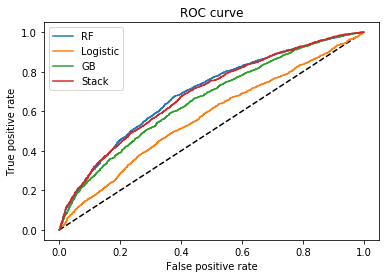

In [67]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_log, tpr_log, label='Logistic')
plt.plot(fpr_gb, tpr_gb, label='GB')
plt.plot(fpr_st, tpr_st, label='Stack')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [68]:
met_df

,auc_gb,auc_rf,auc_st,mse_gb,mse_rf,mse_st,pirce_increase_mean,pirce_increase_median,price_increase_gb,price_increase_gbm,...,price_increase_rf,price_increase_rfm,price_increase_st,price_increase_stm,r2_gb,r2_rf,r2_st,score_gb,score_log,score_rf
0,0.662077,0.694438,0.691254,0.158734,0.165139,0.160623,0.133240,0.0,0.000270,0.880095,...,0.002860,0.838694,0.000978,0.891787,0.154719,0.120611,0.144657,0.619591,0.541880,0.647510
1,0.645788,0.687892,0.680664,0.155056,0.157225,0.154568,1.021935,0.0,0.001634,8.969430,...,0.001445,7.981058,0.004654,8.691498,0.145645,0.133694,0.148330,0.609586,0.546301,0.635644
2,0.649056,0.696172,0.685577,0.167615,0.171365,0.167913,0.499041,0.0,0.000280,3.732613,...,0.004265,3.347054,0.001237,3.451009,0.145190,0.126064,0.143670,0.603304,0.535365,0.638902
3,0.637651,0.685655,0.673617,0.157517,0.161110,0.157688,0.108765,0.0,0.002143,0.789245,...,0.011321,0.730412,0.005708,0.771411,0.154678,0.135397,0.153759,0.596557,0.543741,0.628432
4,0.655841,0.696936,0.689100,0.159307,0.162872,0.159562,0.210475,0.0,0.002800,1.532220,...,0.015205,1.413357,0.007246,1.444230,0.177548,0.159140,0.176232,0.614472,0.540717,0.640996
5,0.640225,0.681736,0.672974,0.159669,0.162749,0.159650,0.836258,0.0,0.007373,6.899677,...,0.012113,6.358847,0.016944,6.771074,0.137827,0.121198,0.137929,0.599814,0.536761,0.635877
6,0.644163,0.688789,0.679011,0.183060,0.183044,0.181149,0.605602,0.0,0.000000,4.742320,...,0.000000,4.493887,0.000079,4.772933,0.092104,0.092186,0.101585,0.603769,0.541415,0.638669
7,0.645851,0.689441,0.680507,0.166543,0.169838,0.166620,0.132556,0.0,0.000548,0.687472,...,0.006094,0.676159,0.007611,0.703736,0.128925,0.111692,0.128521,0.610284,0.533737,0.639832
8,0.641719,0.690787,0.677293,0.178852,0.183632,0.179813,0.704321,0.0,0.000000,5.999471,...,0.001076,5.727077,0.000158,5.770674,0.092523,0.068270,0.087649,0.600884,0.549220,0.636258
9,0.656278,0.690882,0.685057,0.174092,0.175483,0.173328,0.107754,0.0,0.000292,0.553847,...,0.005405,0.514247,0.001700,0.560196,0.132959,0.126033,0.136763,0.609030,0.541541,0.645567


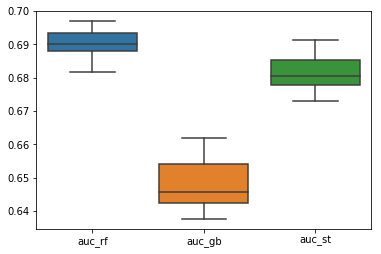

In [81]:
sns.boxplot(data = met_df[['auc_rf', 'auc_gb', 'auc_st']])
plt.show()

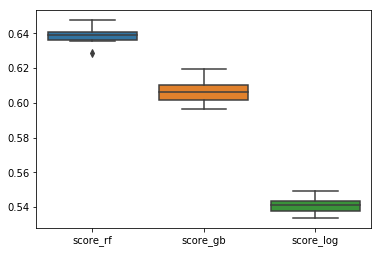

In [70]:
sns.boxplot(data = met_df[['score_rf', 'score_gb', 'score_log']])
plt.show()

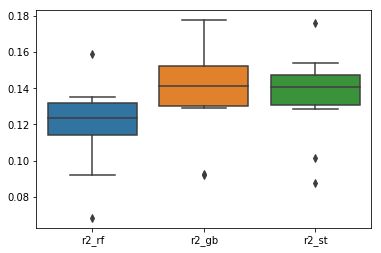

In [71]:
sns.boxplot(data = met_df[['r2_rf', 'r2_gb', 'r2_st']])
plt.show()

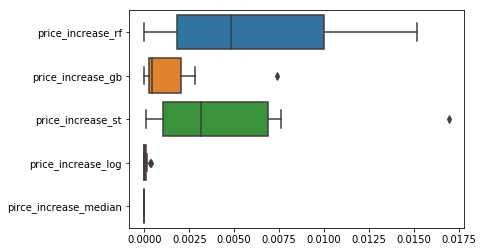

In [84]:
sns.boxplot(data = met_df[['price_increase_rf', 'price_increase_gb', 'price_increase_st', 'price_increase_log', 'pirce_increase_median']],
           orient = 'h')
plt.show()

In [73]:
sum(probs1[:, 1] > .6)

272

In [74]:
sum((probs3[:,1] > .65) & (pred2 > .05))

512

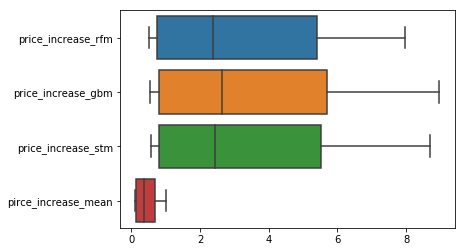

In [83]:
sns.boxplot(data = met_df[['price_increase_rfm', 'price_increase_gbm', 'price_increase_stm', 'pirce_increase_mean']], 
           orient = 'h')
plt.show()

### Conclusions

In [76]:
def impl_vol_func(vol, df):
    from scipy.stats import norm
    
    rf = df['rf']
    t = df['time_left']
    top_d1 = np.log( df.indexPrice/df.strike) + (rf + ((vol)**2)/2)*t
    bottom_d1 = vol * np.sqrt(t)
    d1 = top_d1/bottom_d1

    d2 = d1 - vol * np.sqrt(t)
    if df.option_type == 'C':
        return  df.price - (df.indexPrice*norm.cdf(d1) - df.strike * np.exp(-rf*t) * norm.cdf(d2))
    else:
        return df.price - (df.strike * np.exp(-rf * t) * norm.cdf(-d2) - df.indexPrice * norm.cdf(-d1))
def vega(vol, df):
    from scipy.stats import norm
    
    rf = df['rf']
    t = df['time_left']

    top_d1 = np.log(df.indexPrice/df.strike) + (rf + ((vol)**2)/2)*t
    bottom_d1 = vol * np.sqrt(t)
    d1 = top_d1/bottom_d1
    return df.indexPrice * np.sqrt(t) * norm.cdf(d1, 0.0, 1.0)

def get_implied_vol(df):
    from scipy.optimize import fsolve
    
    impl_vol = fsolve(impl_vol_func, df['sd'], args = (df,), fprime = vega)
    
    return impl_vol[0]

In [77]:
from datetime import datetime
this_year = df2.loc[df2['timeStamp'] >= datetime(2018,1,1)]

In [78]:
warnings.filterwarnings('ignore')
this_year['implied_vol'] = this_year.apply(get_implied_vol, axis = 1)

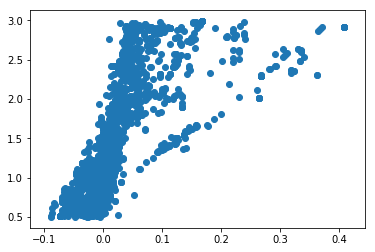

In [79]:
only_calls = this_year.loc[(this_year['implied_vol'] > .5) & (this_year['implied_vol'] < 3) & (this_year['option_type'] == 1)]
plt.scatter(only_calls['strike_dist'], only_calls['implied_vol'])
plt.show()

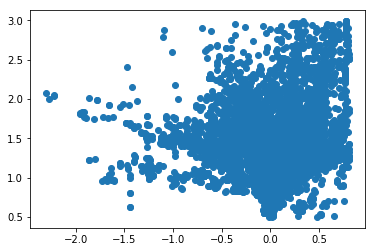

In [80]:
only_puts = this_year.loc[(this_year['implied_vol'] > .5) & (this_year['implied_vol'] < 3) & (this_year['option_type'] == 2)]
plt.scatter(only_puts['strike_dist'], only_puts['implied_vol'])
plt.show()